# Avance 1 — EDA de Casos de Prueba (Cotizaciones/Pedidos)
**Equipo:** 3 • **Fecha:** 2025-09-29

Metricas en este Notebook: univariante (histos/boxplots), categóricas (barras),
bi/multivariante (correlación numérica + crosstab + Cramér’s V), preprocesamiento (faltantes, outliers, cardinalidad),
selección de características (2.1) para recuperación (TF-IDF + SVD con **fix robusto**), y export limpio.


## 0) Configuración y carga de datos

In [9]:
import warnings, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.stats import chi2_contingency

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
plt.rcParams.update({"figure.figsize": (8,5)})

# Ruta del CSV desde la carpeta notebooks/
DATA_PATH = Path("../data/raw/TestCases.csv")
assert DATA_PATH.exists(), f"No se encontró {DATA_PATH}. Coloca el archivo y vuelve a ejecutar."

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.dtypes)
display(df.head(3))


Shape: (4, 13)


case_id            object
title              object
preconditions      object
steps              object
expected_result    object
obtained_result    object
observations       object
exec_count          int64
test_status        object
feature_name       object
sprint              int64
created_at         object
module             object
dtype: object

,case_id,title,preconditions,steps,expected_result,obtained_result,observations,exec_count,test_status,feature_name,sprint,created_at,module
0,1-HU1-1,Visualización de la opción 'Cotización' en el ...,Haber accedido al 'Portal de Clientes',"1) Filtrar el cliente por RNC, nombre o Código...",La opción 'Cotización' aparece correctamente e...,La opción 'Cotización' aparece correctamente e...,NaN,3,Ejecución exitosa,Ingresar al módulo de cotizaciones,1,2025-01-03,Cotizaciones
1,1-HU1-2,Redirección a la página de Cotizaciones al hac...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,El usuario es redirigido correctamente a la pá...,El usuario es redirigido correctamente a la pá...,NaN,3,Ejecución exitosa,Ingresar al módulo de cotizaciones,1,2025-01-03,Cotizaciones
2,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,La página de Cotizaciones carga correctamente ...,La página de Cotizaciones no carga correctamen...,La página se tarda en cargar,2,Falló en su ejecución,Ingresar al módulo de cotizaciones,1,2025-01-03,Cotizaciones


## 1) Normalización de columnas (alias) y tipos

In [10]:
alias = {
    "case_id": ["case_id","id","Id","ID","codigo","código","id caso","id_cp","id cp"],
    "title": ["title","titulo","título","nombre cp","nombre_cp","nombre del caso","nombre","NOMBRE CP","NOMBRE"],
    "preconditions": ["preconditions","precondiciones","pre-condiciones","precondición","precondicion","precondiciones cp","Precondición"],
    "steps": ["steps","pasos","procedimiento","instrucciones","PASOS"],
    "expected_result": ["expected_result","resultado_esperado","resultado esperado","RESULTADO ESPERADO"],
    "obtained_result": ["obtained_result","resultado_obtenido","resultado obtenido","RESULTADO OBTENIDO"],
    "observations": ["observations","observaciones","notas","OBSERVACIONES"],
    "exec_count": ["# ejec","num_ejec","num ejec","ejecuciones","# ejecuciones","# EJEC","#EJEC"],
    "test_status": ["estado de la prueba","estado_prueba","resultado","estado","TEST STATUS","Estado de la prueba"],
    "feature_name": ["nombre de la funcionalidad","funcionalidad","feature","Nombre de la funcionalidad"],
    "sprint": ["sprint","iteracion","iteración","SPRINT"],
    "created_at": ["fecha de creación","fecha_creacion","creado","Fecha de creación"],
    "module": ["module","módulo","modulo","area","área","component","componente","modulo funcional"],
    "type": ["type","tipo","categoria","category","tipo de prueba","tipo prueba","clase de prueba"],
    "priority": ["priority","prioridad","severity","severidad"],
    "estimated_duration_min": ["estimated_duration_min","duracion_min","duración_min","duration","duracion","duración"]
}

def rename_by_alias(df, alias_dict):
    cols = {c.lower(): c for c in df.columns}
    rename_map = {}
    for std, options in alias_dict.items():
        for opt in options:
            k = opt.lower()
            if k in cols:
                rename_map[cols[k]] = std
                break
    return df.rename(columns=rename_map)

df = rename_by_alias(df, alias)
print("Columnas normalizadas:", list(df.columns))

# Casts básicos / trims
for c in ["title","steps","expected_result","obtained_result","preconditions","observations","feature_name"]:
    if c in df.columns:
        df[c] = df[c].fillna("").astype(str).str.strip()

for c in ["module","type","priority","test_status","sprint"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

if "exec_count" in df.columns:
    def to_int(x):
        try:
            return int(float(str(x).strip().replace(",", ".")))
        except:
            return np.nan
    df["exec_count"] = df["exec_count"].apply(to_int)

if "estimated_duration_min" in df.columns:
    def to_num(x):
        try:
            return float(str(x).replace(",", "."))
        except:
            return np.nan
    df["estimated_duration_min"] = df["estimated_duration_min"].apply(to_num)


Columnas normalizadas: ['case_id', 'title', 'preconditions', 'steps', 'expected_result', 'obtained_result', 'observations', 'exec_count', 'test_status', 'feature_name', 'sprint', 'created_at', 'module']


## 2) Estandarizar estado de prueba (pass/fail/not_run/blocked)

In [11]:
STATUS_MAP = {
    "ejecución exitosa": "pass", "ejecucion exitosa": "pass", "ok": "pass", "exitoso": "pass", "exitosamente": "pass",
    "falló en su ejecución": "fail", "fallo en su ejecucion": "fail", "falló": "fail", "fail": "fail", "no cumple": "fail",
    "no se ejecutó": "not_run", "no se ejecuto": "not_run", "pendiente": "not_run",
    "el componente no esta listo": "blocked", "bloqueada": "blocked", "bloqueado": "blocked"
}

def normalize_status(x: str):
    if not isinstance(x, str) or not x.strip():
        return np.nan
    s = x.strip().lower()
    if s in STATUS_MAP:
        return STATUS_MAP[s]
    if "exitosa" in s or "exitos" in s or s == "ok":
        return "pass"
    if "fall" in s or "error" in s:
        return "fail"
    if "no se ejec" in s or "pend" in s:
        return "not_run"
    if "bloque" in s or "no esta listo" in s or "no está listo" in s:
        return "blocked"
    return s

if "test_status" in df.columns:
    df["status_std"] = df["test_status"].apply(normalize_status)
else:
    df["status_std"] = np.nan

print(df["status_std"].value_counts(dropna=False))


status_std
pass    3
fail    1
Name: count, dtype: int64


## 3) Faltantes, duplicados y longitudes de texto

In [12]:
na_counts = df.isna().sum().sort_values(ascending=False)
na_pct = (df.isna().mean()*100).sort_values(ascending=False)
missing_table = pd.concat([na_counts, na_pct], axis=1)
missing_table.columns = ["faltantes", "%"]
display(missing_table.head(20))

dups = df.duplicated().sum()
print(f"[Preprocesamiento] Duplicados exactos detectados: {dups}")
if dups > 0:
    df = df.drop_duplicates()
    print("[Preprocesamiento] Se eliminaron duplicados exactos.")

for c in ["title","steps","expected_result","obtained_result","preconditions","observations"]:
    if c in df.columns:
        df[c+"_len"] = df[c].str.len()


,faltantes,%
case_id,0,0.0
title,0,0.0
preconditions,0,0.0
steps,0,0.0
expected_result,0,0.0
obtained_result,0,0.0
observations,0,0.0
exec_count,0,0.0
test_status,0,0.0
feature_name,0,0.0


[Preprocesamiento] Duplicados exactos detectados: 0


## 4) Univariante: descriptivos, histogramas y boxplots

,count,mean,std,min,25%,50%,75%,max
exec_count,4.0,2.75,0.500000,2.0,2.75,3.0,3.00,3.0
title_len,4.0,73.25,20.139100,55.0,64.00,68.0,77.25,102.0
steps_len,4.0,107.75,66.560123,59.0,59.00,86.0,134.75,200.0
expected_result_len,4.0,71.00,10.739336,64.0,65.50,66.5,72.00,87.0
obtained_result_len,4.0,71.75,12.230427,64.0,65.50,66.5,72.75,90.0
preconditions_len,4.0,65.75,18.500000,38.0,65.75,75.0,75.00,75.0
observations_len,4.0,7.00,14.000000,0.0,0.00,0.0,7.00,28.0


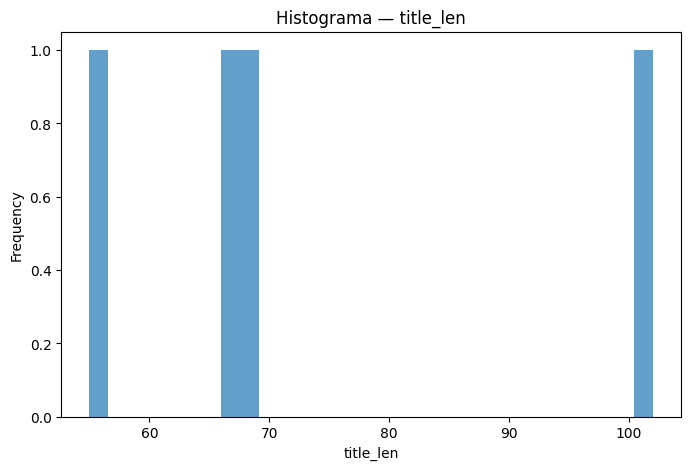

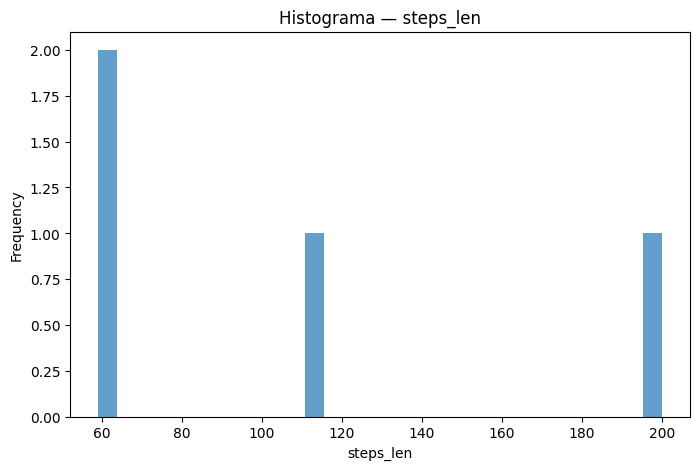

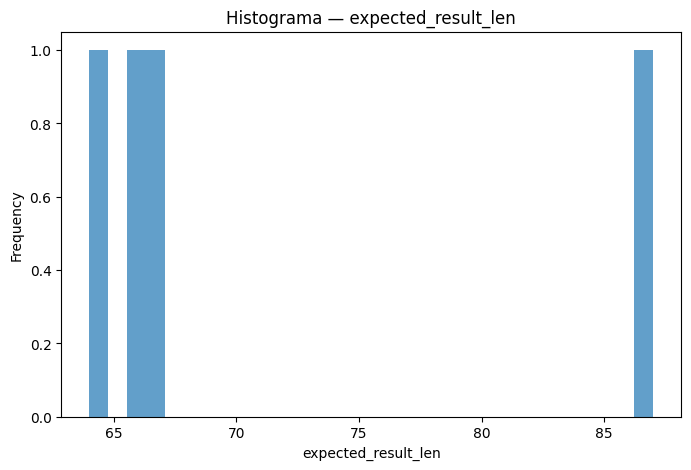

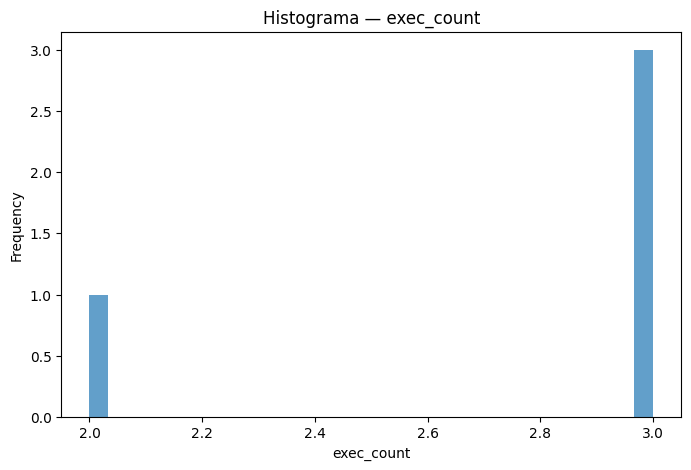

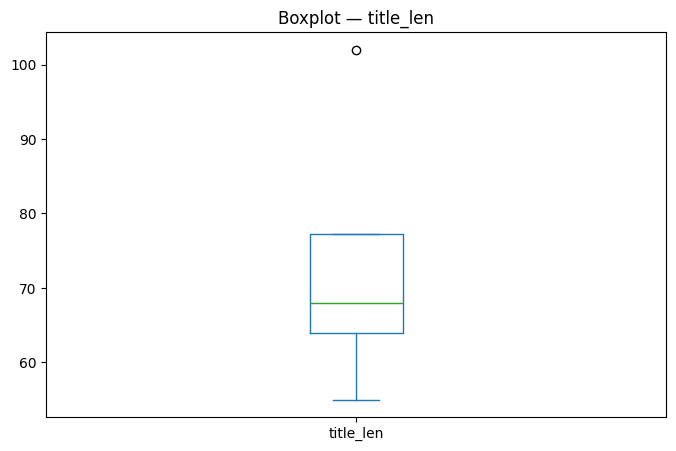

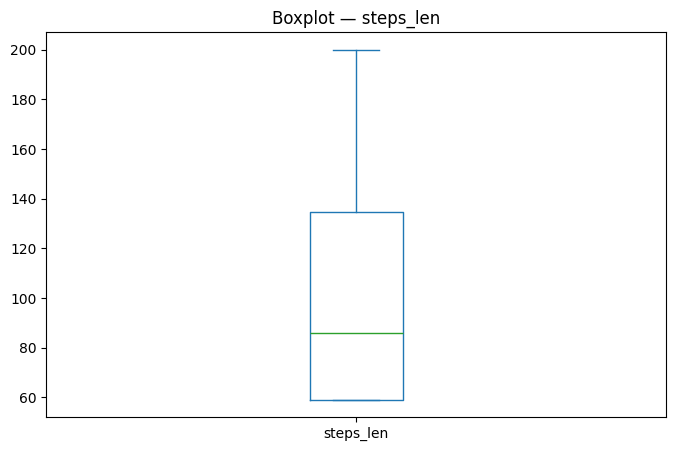

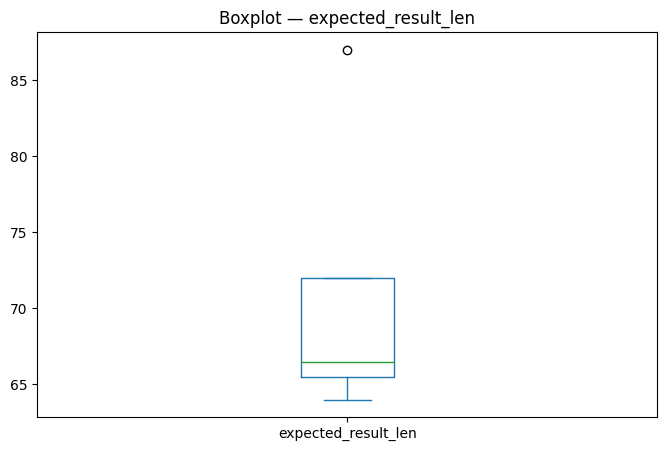

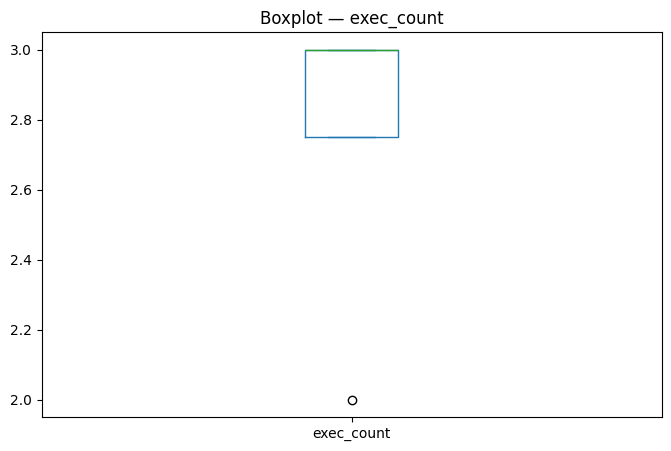

In [13]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
display(df[num_cols].describe().T if num_cols else "No hay numéricas")

# Histogramas principales
for c in ["title_len","steps_len","expected_result_len","estimated_duration_min","exec_count"]:
    if c in df.columns:
        df[c].plot(kind="hist", bins=30, alpha=0.7)
        plt.title(f"Histograma — {c}")
        plt.xlabel(c)
        plt.show()

# Boxplots principales
for c in [x for x in ["estimated_duration_min","estimated_duration_min_log1p",
                      "title_len","steps_len","expected_result_len","exec_count"] if x in df.columns]:
    df[[c]].plot(kind="box", vert=True)
    plt.title(f"Boxplot — {c}")
    plt.show()


## 5) Outliers y transformaciones (duración si existe)

In [14]:
if "estimated_duration_min" in df.columns:
    q01 = df["estimated_duration_min"].quantile(0.01)
    q99 = df["estimated_duration_min"].quantile(0.99)
    df["estimated_duration_min"] = df["estimated_duration_min"].clip(q01, q99)
    skew = df["estimated_duration_min"].skew()
    if skew > 1:
        df["estimated_duration_min_log1p"] = np.log1p(df["estimated_duration_min"])
        df["estimated_duration_min_log1p"].plot(kind="hist", bins=30, alpha=0.7)
        plt.title("Histograma — estimated_duration_min_log1p")
        plt.show()
    print(f"[Justificación] Duración sesgada (skew={skew:.2f}). Cap p1–p99 y log1p si skew>1.")


## 6) Inferencia de módulo y reducción de cardinalidad + barras (frecuencias)

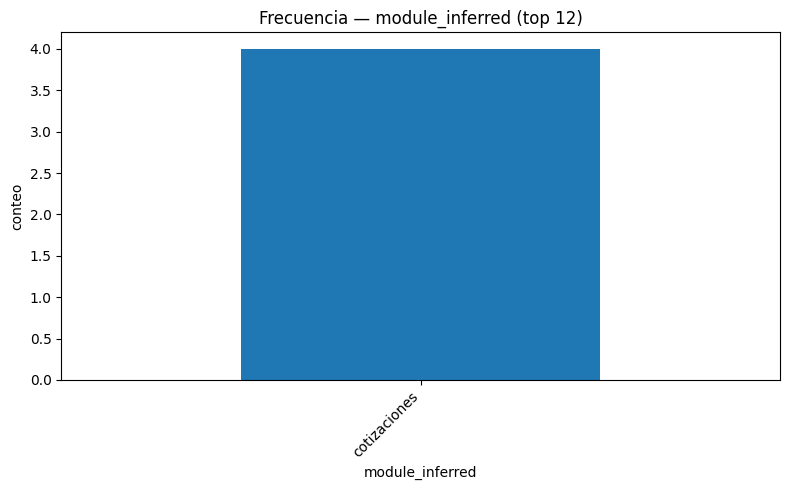

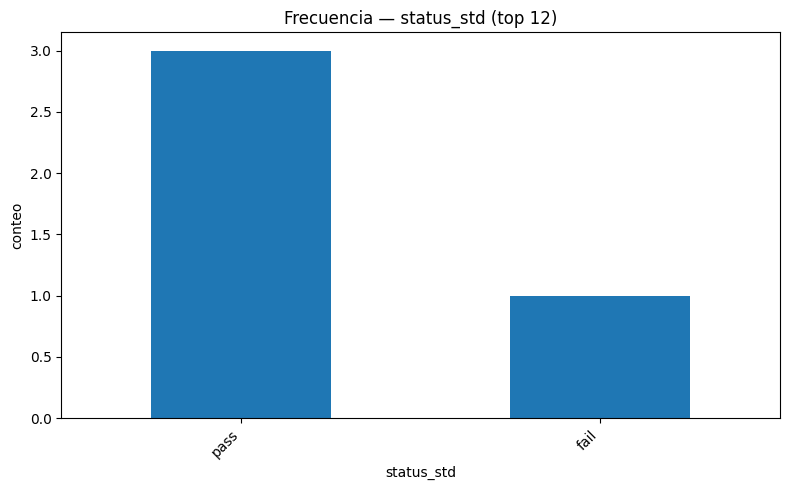

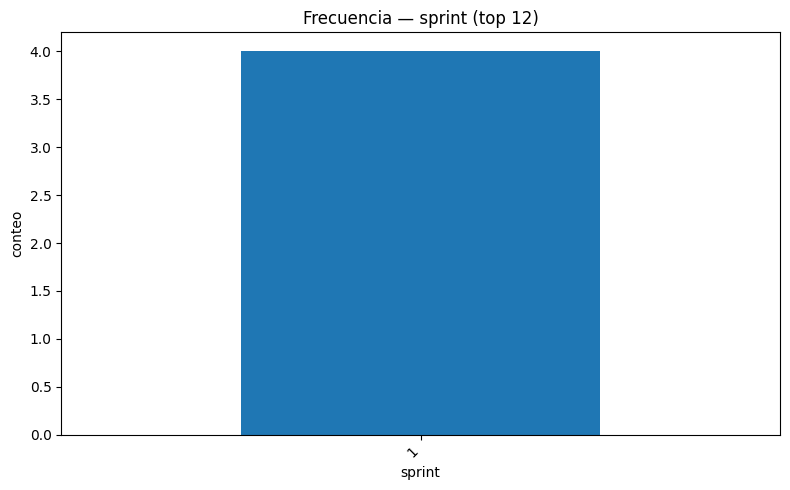

In [15]:
def infer_module(row):
    if "module" in row and isinstance(row["module"], str) and row["module"].strip():
        return row["module"].strip().lower()
    text = " ".join([str(row.get(k, "")) for k in ["feature_name","title","steps"]]).lower()
    if any(k in text for k in ["cotizacion","cotización","cotizaciones"]): return "cotizaciones"
    if "pedido" in text or "pedidos" in text: return "pedidos"
    if "precio" in text or "precios" in text: return "precios"
    if "impuesto" in text or "impuestos" in text: return "impuestos"
    if "cliente" in text or "clientes" in text: return "clientes"
    return "otros"

df["module_inferred"] = df.apply(infer_module, axis=1)

TOPN = 10
for c in ["module_inferred","type"]:
    if c in df.columns:
        top = df[c].value_counts().head(TOPN).index
        df[c+"_grp"] = np.where(df[c].isin(top), df[c], "otros")

TOPB = 12
for c in [x for x in ["module_inferred","type","status_std","sprint"] if x in df.columns]:
    vc = df[c].value_counts(dropna=False).head(TOPB)
    ax = vc.plot(kind="bar")
    ax.set_title(f"Frecuencia — {c} (top {TOPB})")
    ax.set_xlabel(c); ax.set_ylabel("conteo")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


## 7) Candidatos a SMOKE (reglas simples)

Proporción smoke candidates: 1.0


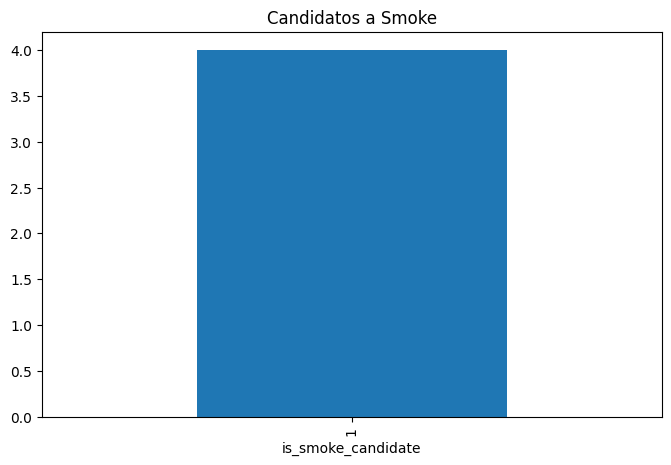

In [17]:
core_modules = {"cotizaciones","pedidos","precios","impuestos","clientes"}
def is_smoke(row):
    score = 0
    if row.get("module_inferred") in core_modules: score += 1
    if row.get("steps_len", 9999) <= 600: score += 1
    if row.get("status_std", "") == "pass": score += 1
    t = str(row.get("title","")).lower()
    if any(k in t for k in ["visualización","visualizacion","redirig","cargar","contenido correcto","opción","opcion"]): score += 1
    ec = row.get("exec_count", np.nan)
    if isinstance(ec, (int,float)) and not np.isnan(ec) and ec >= 1: score += 1
    return 1 if score >= 3 else 0

df["is_smoke_candidate"] = df.apply(is_smoke, axis=1)
print("Proporción smoke candidates:", round(df["is_smoke_candidate"].mean(), 3))
df["is_smoke_candidate"].value_counts().plot(kind="bar"); plt.title("Candidatos a Smoke"); plt.show()


## 8) Bi/Multivariante: Crosstab, Cramér’s V y correlación numérica

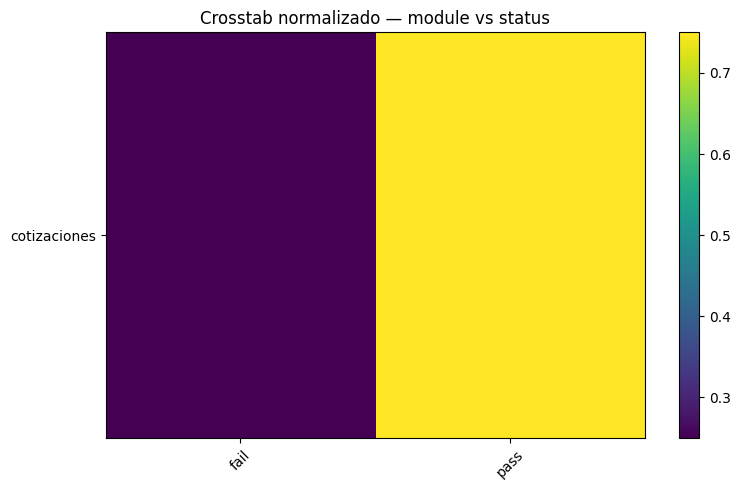

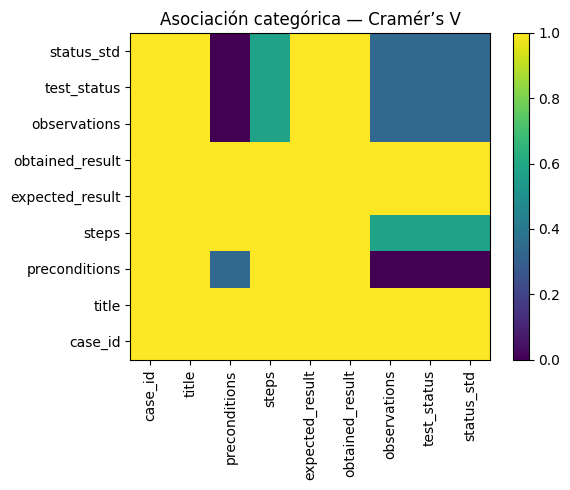

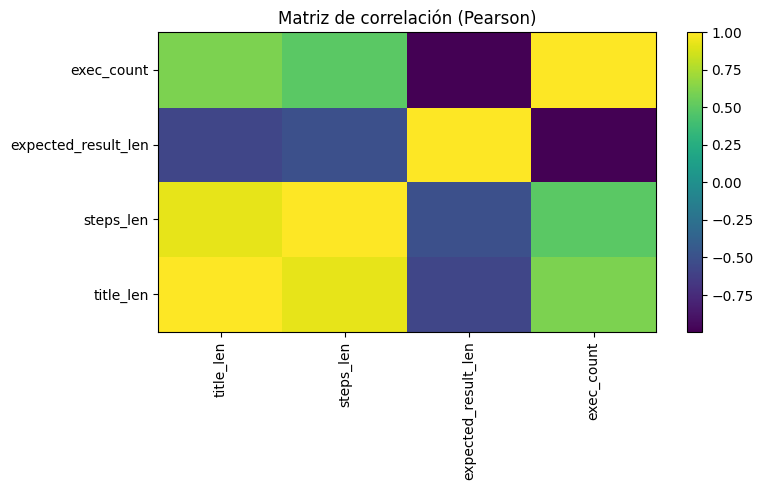

[Justificación] Textos imputados a vacío; categorías unificadas; cardinalidad reducida con top-N + 'otros'.
[Justificación] Estado estandarizado (status_std) e inferencia de módulo (module_inferred).


In [18]:
# Crosstab normalizado: module vs status
if ("module_inferred_grp" in df.columns) and ("status_std" in df.columns):
    ct = pd.crosstab(df["module_inferred_grp"], df["status_std"], normalize="index")
    plt.imshow(ct.values, aspect="auto")
    plt.colorbar(); plt.title("Crosstab normalizado — module vs status")
    plt.yticks(range(len(ct.index)), ct.index); plt.xticks(range(len(ct.columns)), ct.columns, rotation=45)
    plt.tight_layout(); plt.show()

# Cramér’s V para categóricas (<=20 niveles)
def cramers_v(cm):
    chi2 = chi2_contingency(cm)[0]
    n = cm.sum().sum()
    r, k = cm.shape
    return np.sqrt((chi2/n) / (min(k-1, r-1)))

cats = [c for c in df.columns if (df[c].dtype == 'object' or c.endswith("_grp") or c in ["status_std"])]
cats = [c for c in cats if df[c].nunique() > 1 and df[c].nunique() <= 20]
if cats:
    cv = pd.DataFrame(index=cats, columns=cats, dtype=float)
    for i in cats:
        for j in cats:
            try:
                cm = pd.crosstab(df[i], df[j])
                cv.loc[i,j] = cramers_v(cm)
            except Exception:
                cv.loc[i,j] = np.nan
    fig, ax = plt.subplots(figsize=(6,5))
    cax = ax.pcolor(cv.values.astype(float))
    ax.set_xticks(np.arange(len(cats)) + 0.5); ax.set_yticks(np.arange(len(cats)) + 0.5)
    ax.set_xticklabels(cats, rotation=90); ax.set_yticklabels(cats)
    fig.colorbar(cax); plt.title("Asociación categórica — Cramér’s V")
    plt.tight_layout(); plt.show()

# Correlación entre numéricas clave
num_for_corr = [c for c in ["title_len","steps_len","expected_result_len","exec_count",
                            "estimated_duration_min","estimated_duration_min_log1p"] if c in df.columns]
if len(num_for_corr) >= 2:
    corr = df[num_for_corr].corr()
    fig, ax = plt.subplots()
    cax = ax.pcolor(corr.values)
    ax.set_xticks(np.arange(corr.shape[1]) + 0.5); ax.set_yticks(np.arange(corr.shape[0]) + 0.5)
    ax.set_xticklabels(corr.columns, rotation=90); ax.set_yticklabels(corr.index)
    fig.colorbar(cax); plt.title("Matriz de correlación (Pearson)")
    plt.tight_layout(); plt.show()

print("[Justificación] Textos imputados a vacío; categorías unificadas; cardinalidad reducida con top-N + 'otros'.")
print("[Justificación] Estado estandarizado (status_std) e inferencia de módulo (module_inferred).")


## 9) Features de recuperación (TF-IDF + SVD) con FIX robusto y export

In [19]:
# Construir texto completo
for c in ["title","preconditions","steps","expected_result","obtained_result","observations"]:
    if c not in df.columns:
        df[c] = ""
df["text_full"] = (
    df["title"].astype(str) + " " + df["preconditions"].astype(str) + " " +
    df["steps"].astype(str) + " " + df["expected_result"].astype(str) + " " +
    df["obtained_result"].astype(str) + " " + df["observations"].astype(str)
)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df["text_full"])

# FIX robusto para datasets pequeños
n_samples, n_features = X_tfidf.shape
if n_samples < 2 or n_features < 2:
    print(f"[SVD] Dataset demasiado pequeño para SVD; omitido. (n_samples={n_samples}, n_features={n_features})")
    X_svd = None
else:
    max_possible = min(n_features - 1, n_samples - 1)
    n_comp = max(1, min(50, max_possible))
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    X_svd = svd.fit_transform(X_tfidf)

# Añadir columnas SVD si existen
if X_svd is not None and X_svd.shape[1] > 0:
    for i in range(X_svd.shape[1]):
        df[f"svd_{i+1}"] = X_svd[:, i]
    print(f"TF-IDF: {X_tfidf.shape} | SVD comps: {X_svd.shape[1]}")
else:
    print(f"TF-IDF: {X_tfidf.shape} | SVD omitido (n_samples={n_samples}, n_features={n_features})")

# Export
processed = Path("../data/processed"); processed.mkdir(parents=True, exist_ok=True)
keep_cols = [c for c in [
    "case_id","title","preconditions","steps","expected_result","obtained_result","observations",
    "feature_name","sprint","created_at",
    "module","module_inferred","module_inferred_grp",
    "type","type_grp","priority",
    "exec_count","test_status","status_std",
    "estimated_duration_min","estimated_duration_min_log1p",
    "title_len","steps_len","expected_result_len","obtained_result_len","preconditions_len","observations_len",
    "is_smoke_candidate"
] if c in df.columns]
clean = df[keep_cols + [c for c in df.columns if c.startswith("svd_")]].copy()
out_path = processed / "TestCases_clean_features.csv"
clean.to_csv(out_path, index=False)
print("[Export] Guardado:", out_path)


TF-IDF: (4, 58) | SVD comps: 3
[Export] Guardado: ..\data\processed\TestCases_clean_features.csv


## 10) Verificación y evidencia de ejecución

In [21]:
import json, os, sys, time, platform, hashlib, getpass
from pathlib import Path

def sha256(path: Path):
    if not path.exists():
        return None
    h = hashlib.sha256()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(8192), b''):
            h.update(chunk)
    return h.hexdigest()

raw = Path("../data/raw/TestCases.csv")
proc = Path("../data/processed/TestCases_clean_features.csv")

shape = tuple(df.shape) if 'df' in globals() else None
smoke = int(df['is_smoke_candidate'].sum()) if 'df' in globals() and 'is_smoke_candidate' in df else None

import pandas as _pd, numpy as _np, matplotlib as _mpl
try:
    import sklearn as _sk
    sk_ver = _sk.__version__
except Exception:
    sk_ver = None

report = {
    "timestamp_utc": time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime()),
    "python": sys.version,
    "platform": platform.platform(),
    "lib_versions": {
        "pandas": _pd.__version__,
        "numpy": _np.__version__,
        "matplotlib": _mpl.__version__,
        "scikit_learn": sk_ver
    },
    "raw_exists": raw.exists(),
    "raw_sha256": sha256(raw),
    "processed_exists": proc.exists(),
    "processed_sha256": sha256(proc),
    "df_shape": shape,
    "smoke_candidates": smoke
}

Path("../run_artifacts").mkdir(parents=True, exist_ok=True)
with open("../run_artifacts/run_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
with open("../run_artifacts/RUN_OK.txt", "w", encoding="utf-8") as f:
    f.write("Avance 1 ejecutado correctamente.\n")
    f.write(json.dumps({"shape": shape, "smoke_candidates": smoke}, ensure_ascii=False))

print("✔ Evidencia escrita en: ../run_artifacts/run_report.json y ../run_artifacts/RUN_OK.txt")
print("   df.shape:", shape, "| smoke_candidates:", smoke)
print("   raw_sha256:", report["raw_sha256"])
print("   processed_sha256:", report["processed_sha256"])

✔ Evidencia escrita en: ../run_artifacts/run_report.json y ../run_artifacts/RUN_OK.txt
   df.shape: (4, 27) | smoke_candidates: 4
   raw_sha256: d78a29d14b9fcaefb8f4f06822aa67a014955cdc15d65defaa7aec7d8462f6a9
   processed_sha256: 0108ecb5a67f4142542dcbd52ce7800cefd126018c632bf5d0e34829c89ea23c
